Lambda School Data Science, Unit 2: Predictive Modeling

# Applied Modeling, Module 3

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploration, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Share at least 1 visualization on Slack.

(If you have not yet completed an initial model yet for your portfolio project, then do today's assignment using your Tanzania Waterpumps model.)

## Stretch Goals
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox.I Get readable category names on your plot, instead of integer category codes.

## Links
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

In [1]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns

import re
import random

import string

!pip install spacy
!python -m spacy download en
import spacy
from spacy.lang.en import English
import string
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.svm import LinearSVC, NuSVC

from sklearn.decomposition import TruncatedSVD

from sklearn.feature_selection import SelectKBest

from sklearn import metrics
from sklearn.utils.multiclass import unique_labels

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from xgboost import XGBClassifier

[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
[x] Couldn't link model to 'en'
Creating a symlink in spacy/data failed. Make sure you have the required
permissions and try re-running the command as admin, or use a virtualenv. You
can still import the model as a module and call its load() method, or create the
symlink manually.
C:\Users\conno\Anaconda3\envs\unit2\lib\site-packages\en_core_web_sm -->
C:\Users\conno\Anaconda3\envs\unit2\lib\site-packages\spacy\data\en
[!] Download successful but linking failed
Creating a shortcut link for 'en' didn't work (maybe you don't have admin
permissions?), but you can still load the model via its full package name: nlp =
spacy.load('en_core_web_sm')


You do not have sufficient privilege to perform this operation.


In [2]:
# load in the tweets
tweets = pd.read_csv('../data/mercal-btc-tweets-sentiment/data/btc_tweets_daily_example.csv')
tweets.head()

,column_a,date,tweet,screen_name,source,link,sentiment,sent_score,new_sentiment_score,new_sentiment_state
0,0,Fri Mar 23 00:40:32 +0000 2018,"RT @ALXTOKEN: Paul Krugman, Nobel Luddite. I h...",myresumerocket,[],"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['neutral'],0,0.000000,0
1,1,Fri Mar 23 00:40:34 +0000 2018,@lopp @_Kevin_Pham @psycho_sage @naval But @Pr...,BitMocro,[u'Bitcoin'],"<a href=""http://twitter.com/download/android"" ...",['neutral'],0,0.000000,0
2,2,Fri Mar 23 00:40:35 +0000 2018,RT @tippereconomy: Another use case for #block...,hojachotopur,"[u'blockchain', u'Tipper', u'TipperEconomy']","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['positive'],1,0.136364,1
3,3,Fri Mar 23 00:40:36 +0000 2018,free coins https://t.co/DiuoePJdap,denies_distro,[],"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['positive'],1,0.400000,1
4,4,Fri Mar 23 00:40:36 +0000 2018,RT @payvxofficial: WE are happy to announce th...,aditzgraha,[],"<a href=""http://twitter.com/download/android"" ...",['positive'],1,0.468182,1


In [3]:
# Dropping unused columns, checking shape

tweets.drop(columns=['column_a','link','sentiment',
             'new_sentiment_score','new_sentiment_state'], inplace=True)

tweets.shape

(50859, 5)

In [4]:
# load in punctuation
punctuations = string.punctuation

# load in stopwords
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# instantiate the english parser
parser = English()

# create a function to tokenize and lemmatize tweets, and remove stopwords and punctuation
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [5]:
def clean_text(text): # Clean our tweets using regex. Remove weird characters and links.
    cleanedup = text.lower()
    return re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", cleanedup)

In [6]:
# initialize vectorizers for vectorizing tweets
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

In [7]:
# clean the tweets, divide into feature and target, divide into train and test

tweets['tweet'] = tweets['tweet'].apply(clean_text)

X = tweets['tweet'] # X 
ylabels = tweets['sent_score'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3)

In [8]:
# prepare a pre-BoW'd version of X
BoW_encoder = bow_vector
X_train_BoW = BoW_encoder.fit_transform(X_train)
X_test_BoW = BoW_encoder.transform(X_test)

drop_dimensions = SelectKBest(k=100)
X_train_kbest = drop_dimensions.fit_transform(X_train_BoW, y_train)
X_test_kbest = drop_dimensions.transform(X_test_BoW)

In [9]:
# Which features were selected?

all_names = pd.Series(BoW_encoder.get_feature_names())
selected_mask = pd.Series(drop_dimensions.get_support())
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

In [10]:
X_train_kbest_df = pd.DataFrame(X_train_kbest.toarray(), columns=selected_names)
X_test_kbest_df = pd.DataFrame(X_test_kbest.toarray(), columns=selected_names)

In [13]:
# evaluation set for early stopping
eval_set = [(X_train_kbest_df, y_train), 
            (X_test_kbest_df,y_test)]

In [14]:
# these parameters aren't well-optimized, plenty more work to do.
# I tried out the DART booster... it's very slow.
model = XGBClassifier(
    n_estimators = 15000, # we'll stop short of this thanks to early stopping
    max_depth = 7,
    learning_rate = 0.15,
    #gamma = 0.05,
    colsample_bytree = 0.3,
    #scale_pos_weight = 0.8,
    booster = 'gbtree',
    n_jobs = -1
)

model.fit(X_train_kbest_df, y_train, 
          eval_set=eval_set, 
          eval_metric='merror',
         early_stopping_rounds=50)

[0]	validation_0-merror:0.393023	validation_1-merror:0.39068
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.332322	validation_1-merror:0.333137
[2]	validation_0-merror:0.335243	validation_1-merror:0.338511
[3]	validation_0-merror:0.294458	validation_1-merror:0.29827
[4]	validation_0-merror:0.288756	validation_1-merror:0.29342
[5]	validation_0-merror:0.287155	validation_1-merror:0.291781
[6]	validation_0-merror:0.285807	validation_1-merror:0.289291
[7]	validation_0-merror:0.284458	validation_1-merror:0.287587
[8]	validation_0-merror:0.287745	validation_1-merror:0.290339
[9]	validation_0-merror:0.285413	validation_1-merror:0.286604
[10]	validation_0-merror:0.28311	validation_1-merror:0.283851
[11]	validation_0-merror:0.27884	validation_1-merror:0.28372
[12]	validation_0-merror:0.277548	validation_1-merror:0.282278
[13]	validation_0-merror:0.273447	

[128]	validation_0-merror:0.255386	validation_1-merror:0.261109
[129]	validation_0-merror:0.255386	validation_1-merror:0.261109
[130]	validation_0-merror:0.255302	validation_1-merror:0.260978
[131]	validation_0-merror:0.25533	validation_1-merror:0.260978
[132]	validation_0-merror:0.25533	validation_1-merror:0.260978
[133]	validation_0-merror:0.25533	validation_1-merror:0.260978
[134]	validation_0-merror:0.255049	validation_1-merror:0.26065
[135]	validation_0-merror:0.255049	validation_1-merror:0.26065
[136]	validation_0-merror:0.255077	validation_1-merror:0.260585
[137]	validation_0-merror:0.254768	validation_1-merror:0.260519
[138]	validation_0-merror:0.254768	validation_1-merror:0.260519
[139]	validation_0-merror:0.254768	validation_1-merror:0.260519
[140]	validation_0-merror:0.254768	validation_1-merror:0.260519
[141]	validation_0-merror:0.254684	validation_1-merror:0.260388
[142]	validation_0-merror:0.2546	validation_1-merror:0.260388
[143]	validation_0-merror:0.2546	validation_1-m

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.15, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=15000, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

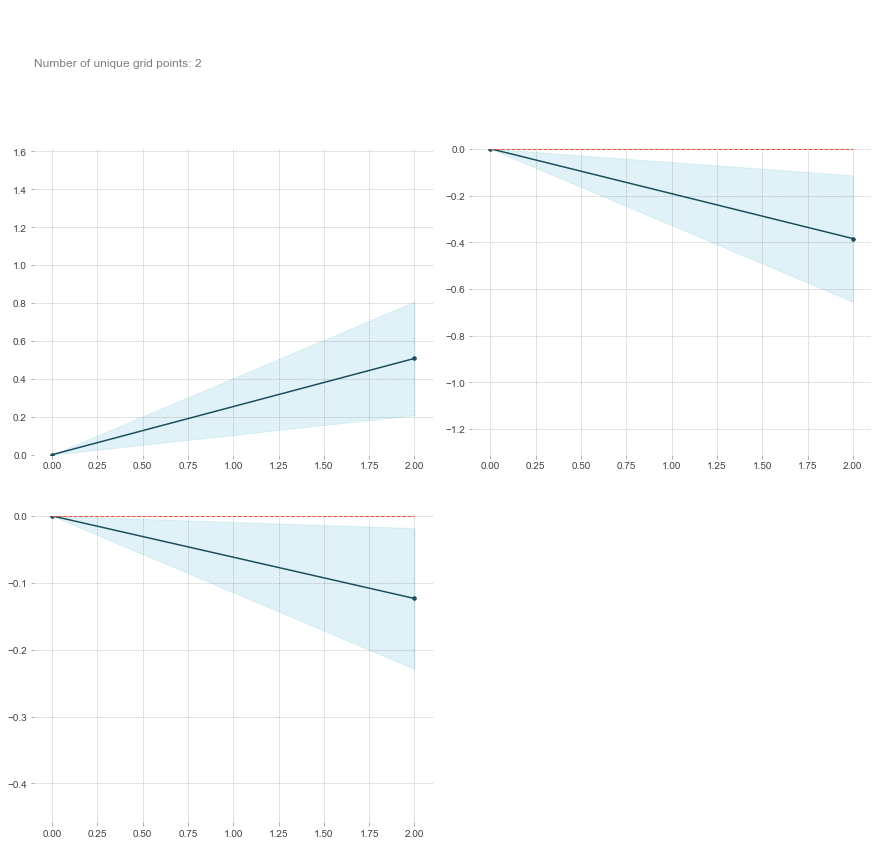

In [15]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'illegal'

isolated = pdp_isolate(
    model = model,
    dataset = X_test_kbest_df,
    model_features=X_test_kbest_df.columns,
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

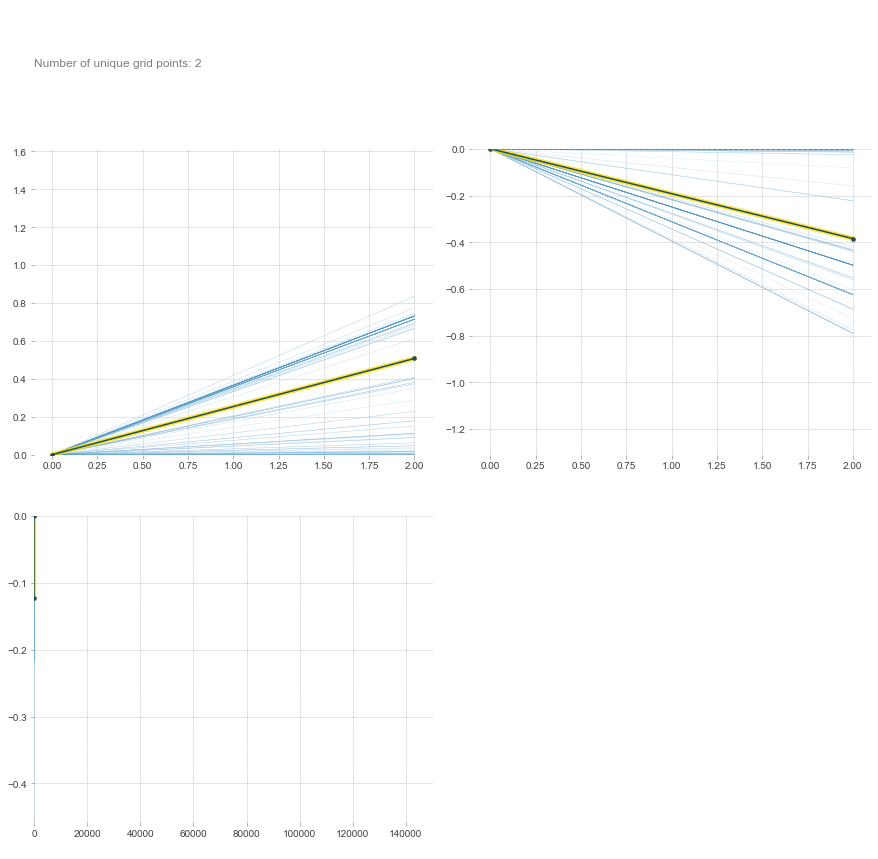

In [16]:
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=100)
plt.xlim(0,150000);